## Common Libraries

In [9]:
import matplotlib.pyplot as plt
import matplotlib
params = {'axes.titlesize':'14',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14',
          'font.size':'14',
          'legend.fontsize':'medium',
          'lines.linewidth':'2',
          'font.weight':'normal',
          'lines.markersize':'10'
          }
matplotlib.rcParams.update(params)
plt.rcParams["mathtext.fontset"] = "cm"
plt.rc('font', family='serif')

import time
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

## Importing Longitudinal/Multidimensional Protocols from multi_freq_ldpy

In [2]:
from multi_freq_ldpy.long_mdim_freq_est.L_SPL_Solution import *
from multi_freq_ldpy.long_mdim_freq_est.L_SMP_Solution import *

## Reading Nursery dataset

In [3]:
df = pd.read_csv('datasets/db_nursery.csv')
df

,parents,has_nurs,form,children,housing,finance,social,health,NURSERY
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


## Encoding values

In [4]:
LE = LabelEncoder()

attributes = df.columns

for col in attributes:

    df[col] = LE.fit_transform(df[col])
df

,parents,has_nurs,form,children,housing,finance,social,health,NURSERY
0,2,3,0,0,0,0,0,2,2
1,2,3,0,0,0,0,0,1,1
2,2,3,0,0,0,0,0,0,0
3,2,3,0,0,0,0,2,2,2
4,2,3,0,0,0,0,2,1,1
...,...,...,...,...,...,...,...,...,...
12955,0,4,2,3,1,1,2,1,3
12956,0,4,2,3,1,1,2,0,0
12957,0,4,2,3,1,1,1,2,3
12958,0,4,2,3,1,1,1,1,3


## Static Parameteres

In [5]:
# number of users
n = df.shape[0]
print('Number of Users =',n)

# number of attributes
d = len(attributes)
print('Number of Attributes =', d)

# domain size of attributes
lst_k = [len(df[att].unique()) for att in attributes]
print('Domain size of attributes =', lst_k)

print("\nPrivacy guarantees:")

# upper bound (infinity reports)
lst_eps_perm = np.arange(0.5, 5.1, 0.5)
print("List of epsilon_perm =", lst_eps_perm)

#lower bound (single report)
lst_eps_1 = lst_eps_perm * 0.5
print("List of epsilon_1 =", lst_eps_1)

Number of Users = 12960
Number of Attributes = 9
Domain size of attributes = [3, 5, 4, 4, 3, 2, 3, 3, 5]

Privacy guarantees:
List of epsilon_perm = [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
List of epsilon_1 = [0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5 ]


## Comparison of multidimensional solutions with longitudinal protocols

In [6]:
# Real normalized frequencies
real_freq = [np.unique(df[att], return_counts=True)[-1] / n for att in attributes]

# Repeat nb_seed times since DP protocols are randomized
nb_seed = 50

# Save Averaged Mean Squared Error (MSE_avg) between real and estimated frequencies per seed
dic_avg_mse = {seed: 
                   {"SPL_L_ADP": [], # Splitting solution with Adaptive protocol (i.e., L-GRR or L-OSUE)
                    "SPL_L_SUE": [], # Splitting solution with Basic RAPPOR protocols (i.e., L-SUE)
                    "SMP_L_ADP": [], # Sampling solution with Adaptive protocol (i.e., L-GRR or L-OSUE)
                    "SMP_L_SUE": [], # Sampling solution with Basic RAPPOR protocols (i.e., L-SUE)
                   } 
                   for seed in range(nb_seed)
              }

starttime = time.time()
for seed in range(nb_seed):
    print('Starting w/ seed:', seed)

    for idx_eps in range(len(lst_eps_perm)):

        eps_perm = lst_eps_perm[idx_eps]
        eps_1 = lst_eps_1[idx_eps]
        
        # SPL solution with L-ADP protocol (i.e., L-GRR or L-OSUE)
        spl_reports = [SPL_L_ADP_Client(input_data, lst_k, d, eps_perm, eps_1) for input_data in df.values]
        spl_est_freq = SPL_L_ADP_Aggregator(spl_reports, lst_k, d, eps_perm, eps_1)
        dic_avg_mse[seed]["SPL_L_ADP"].append(np.mean([mean_squared_error(real_freq[att], spl_est_freq[att]) for att in range(d)]))
        
        # SPL solution with L-SUE protocol (i.e., Basic RAPPOR)
        spl_sue_reports = [SPL_L_SUE_Client(input_data, lst_k, d, eps_perm, eps_1) for input_data in df.values]
        spl_sue_est_freq = SPL_L_SUE_Aggregator(spl_sue_reports, d, eps_perm, eps_1)
        dic_avg_mse[seed]["SPL_L_SUE"].append(np.mean([mean_squared_error(real_freq[att], spl_sue_est_freq[att]) for att in range(d)]))

        # SMP solution with L-ADP protocol (i.e., L-GRR or L-OSUE)
        smp_reports = [SMP_L_ADP_Client(input_data, lst_k, d, eps_perm, eps_1) for input_data in df.values]
        smp_est_freq = SMP_L_ADP_Aggregator(smp_reports, lst_k, d, eps_perm, eps_1)
        dic_avg_mse[seed]["SMP_L_ADP"].append(np.mean([mean_squared_error(real_freq[att], smp_est_freq[att]) for att in range(d)]))
        
        # SMP solution with L-SUE protocol (i.e., Basic RAPPOR)
        smp_sue_reports = [SMP_L_SUE_Client(input_data, lst_k, d, eps_perm, eps_1) for input_data in df.values]
        smp_sue_est_freq = SMP_L_SUE_Aggregator(smp_sue_reports, d, eps_perm, eps_1)
        dic_avg_mse[seed]["SMP_L_SUE"].append(np.mean([mean_squared_error(real_freq[att], smp_sue_est_freq[att]) for att in range(d)]))
        
print('That took {} seconds'.format(time.time() - starttime))        

Starting w/ seed: 0
Starting w/ seed: 1
Starting w/ seed: 2
Starting w/ seed: 3
Starting w/ seed: 4
Starting w/ seed: 5
Starting w/ seed: 6
Starting w/ seed: 7
Starting w/ seed: 8
Starting w/ seed: 9
Starting w/ seed: 10
Starting w/ seed: 11
Starting w/ seed: 12
Starting w/ seed: 13
Starting w/ seed: 14
Starting w/ seed: 15
Starting w/ seed: 16
Starting w/ seed: 17
Starting w/ seed: 18
Starting w/ seed: 19
Starting w/ seed: 20
Starting w/ seed: 21
Starting w/ seed: 22
Starting w/ seed: 23
Starting w/ seed: 24
Starting w/ seed: 25
Starting w/ seed: 26
Starting w/ seed: 27
Starting w/ seed: 28
Starting w/ seed: 29
Starting w/ seed: 30
Starting w/ seed: 31
Starting w/ seed: 32
Starting w/ seed: 33
Starting w/ seed: 34
Starting w/ seed: 35
Starting w/ seed: 36
Starting w/ seed: 37
Starting w/ seed: 38
Starting w/ seed: 39
Starting w/ seed: 40
Starting w/ seed: 41
Starting w/ seed: 42
Starting w/ seed: 43
Starting w/ seed: 44
Starting w/ seed: 45
Starting w/ seed: 46
Starting w/ seed: 47
St

## Plotting metrics results

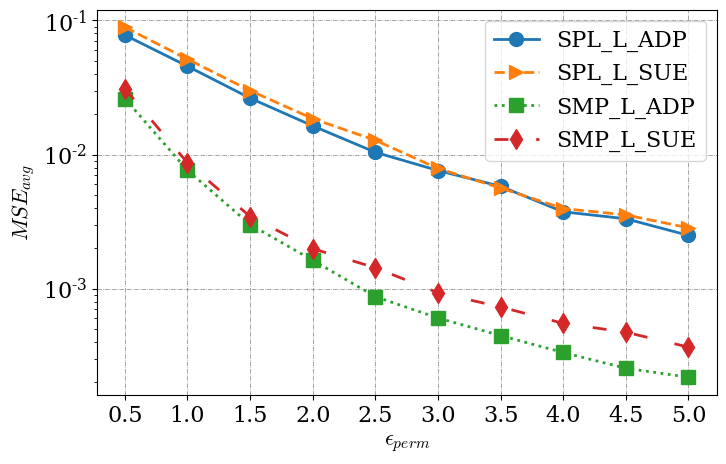

In [8]:
plt.figure(figsize=(8,5))
plt.grid(color='grey', linestyle='dashdot', linewidth=0.5)
plt.plot(np.mean([dic_avg_mse[seed]["SPL_L_ADP"] for seed in range(nb_seed)], axis=0), label='SPL_L_ADP', marker='o')
plt.plot(np.mean([dic_avg_mse[seed]["SPL_L_SUE"] for seed in range(nb_seed)], axis=0), label='SPL_L_SUE',marker='>',linestyle='dashed')
plt.plot(np.mean([dic_avg_mse[seed]["SMP_L_ADP"] for seed in range(nb_seed)], axis=0), label='SMP_L_ADP',marker='s',linestyle='dotted')
plt.plot(np.mean([dic_avg_mse[seed]["SMP_L_SUE"] for seed in range(nb_seed)], axis=0), label='SMP_L_SUE',marker='d',linestyle=(0, (5, 10)))

plt.yscale('log')
plt.xlabel('$\epsilon_{perm}$')
plt.ylabel('$MSE_{avg}$')
plt.xticks(range(len(lst_eps_perm)), lst_eps_perm)
plt.legend(ncol=1)
plt.show();

## Example of Real vs Estimated Freqencies

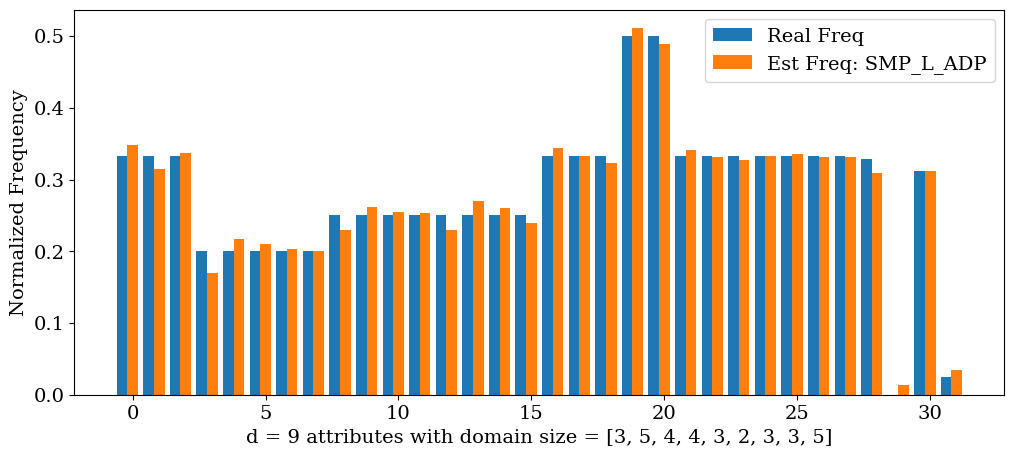

In [13]:
plt.figure(figsize=(12, 5))

barwidth = 0.4
x_axis = np.arange(sum(lst_k))

plt.bar(x_axis - barwidth, np.concatenate(real_freq), label='Real Freq', width=barwidth)
plt.bar(x_axis, np.concatenate(smp_est_freq), label='Est Freq: SMP_L_ADP', width=barwidth)
plt.ylabel('Normalized Frequency')
plt.xlabel('d = {} attributes with domain size = {}'.format(d, lst_k))
plt.legend()
plt.show();